In [1]:
import numpy as np
from scipy.signal import hilbert
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import emd
from scipy.ndimage import gaussian_filter1d
from scipy.fft import fft, fftfreq
from get_signals import get_signals

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

## Расчет значений дополнительных физиологических параметров (раздел отчета 6.2)
Содержание jupyter notebook (ссылки):
1. [Пульс и вариабельность сердечного ритма](#heart)
2. [Частота дыхания](#breath)
3. [Вариабельность артериального давления](#pressure)
4. [Артериальная и венозная сатурация](#sat)

**Загрузка данных.**

In [3]:
filename = 'data/hypothenar_data.xlsx'
r_1 = 1.62
r_2 = 2.22
lmbd_1 = 692
lmbd_2 = 834
sto2, d_hb, d_hbo, d_hhb, d_thb, time, d_mua_lmbd1, d_mua_lmbd2 = get_signals(filename, r_1, r_2, lmbd_1, lmbd_2)

In [4]:
df_real = pd.read_excel('data/Diodes1357_HbUa.xlsx')
thb_real = df_real["THC A"].values
hhb_real = df_real[" [De Oxy] A"].values
hbo_real = df_real[" [Oxy] A"].values

<a id='heart'></a>
### Вычисление пульса и вариабельности сердечного ритма

**На небольшом участке сигнала**

Поиск количества возрастающих фронтов пульсовой волны как количества локальных максимумов производной сигнала D_Hb, соответствующих точкам перегиба на возрастающих фронтах. Локальные максимумы первой производной были найдены как нули сигнала, полученного путем взятия производной от сглаженной первой производной.

Для улучшения точности алгоритма из сигнала были удалены EMD-уровни, соответствующие иным компонентам, кроме пульсовой.

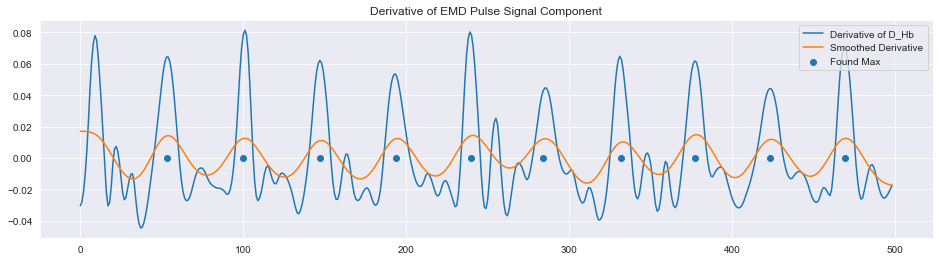

In [5]:
imf = emd.sift.sift(d_hb)
levels = (imf[:, 2]+imf[:, 3])[90*50:100*50]
dy = np.diff(levels)
ddy = np.diff(gaussian_filter1d(dy, 10))
pairs = []
zeros = []
first = -1
second = -1
for i in range(len(ddy) - 1):
    if ddy[i] <= 0 and ddy[i + 1] >= 0:
        first = i
    elif ddy[i] >= 0 and ddy[i + 1] <= 0 and first != -1:
        pairs.append((first, i))
        zeros.append(i)
        first = -1
figure, axis = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(dy)
plt.plot(gaussian_filter1d(dy, 10))
plt.scatter(zeros, np.zeros(len(zeros)))
plt.legend(["Derivative of D_Hb", "Smoothed Derivative", "Found Max"])
plt.title("Derivative of EMD Pulse Signal Component")
plt.show()

Вычисление пульса по средней разности между моментами локальных максимумов

In [6]:
pulse = 60 / (((zeros[-1] - zeros[0]) / 50) / (len(zeros) - 1))
print("Количество ударов в минуту:", np.round(pulse, 1))

Количество ударов в минуту: 64.9


Вычисление вариабельности сердечного ритма как последовательности разностей интервалов времени между соседними пульсовыми колебаниями

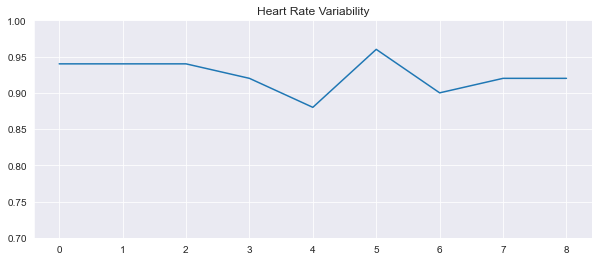

In [7]:
diffs = []
for i in range(len(zeros)-1):
    diffs.append((zeros[i+1] - zeros[i]) / 50)
figure, axis = plt.subplots(1, 1, figsize=(10, 4))
plt.plot(diffs)
plt.ylim([0.7, 1])
plt.title("Heart Rate Variability")
plt.show()

**Вычисление пульса и его вариабельности для всего сигнала**

Производная пульсовой компоненты

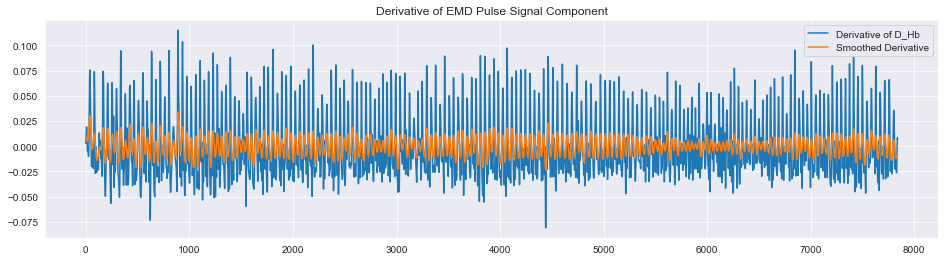

In [8]:
imf = emd.sift.sift(d_hb)
levels = imf[:, 2]+imf[:, 3]
dy = np.diff(levels)
ddy = np.diff(gaussian_filter1d(dy, 10))
pairs = []
zeros = []
first = -1
second = -1
for i in range(len(ddy) - 1):
    if ddy[i] <= 0 and ddy[i + 1] >= 0:
        first = i
    elif ddy[i] >= 0 and ddy[i + 1] <= 0 and first != -1:
        pairs.append((first, i))
        zeros.append(i)
        first = -1
figure, axis = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(dy)
plt.plot(gaussian_filter1d(dy, 10))
plt.legend(["Derivative of D_Hb", "Smoothed Derivative"])
plt.title("Derivative of EMD Pulse Signal Component")
plt.show()

Средний пульс на всем сигнале

In [9]:
pulse = 60 / (((zeros[-1] - zeros[0]) / 50) / (len(zeros) - 1))
print("Количество ударов в минуту на всем сигнале:", np.round(pulse, 1))

Количество ударов в минуту на всем сигнале: 71.5


График вариабельности сердечного ритма

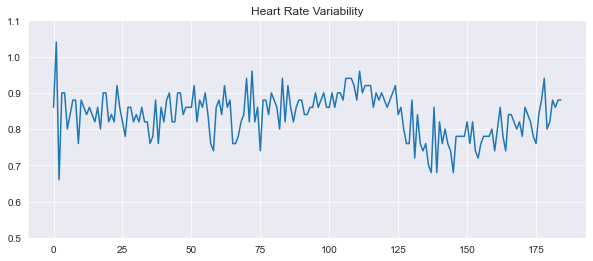

In [10]:
diffs = []
for i in range(len(zeros)-1):
    diffs.append((zeros[i+1] - zeros[i]) / 50)
figure, axis = plt.subplots(1, 1, figsize=(10, 4))
plt.plot(diffs)
plt.ylim([0.5, 1.1])
plt.title("Heart Rate Variability")
plt.show()

Вычисление пульса скользящим окном по 10 сокращений

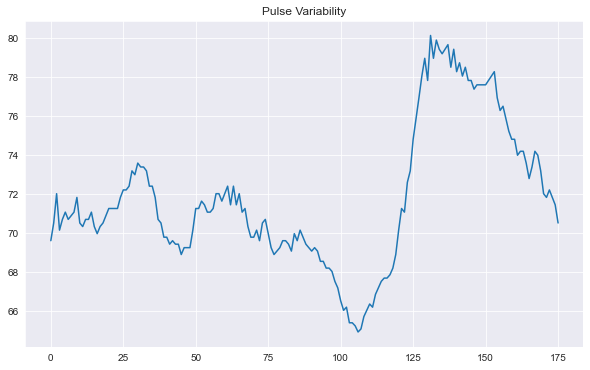

In [11]:
def find_pulse(start, end):
    return 60 / (((zeros[end-1] - zeros[start]) / 50) / (end-start-1))

num_points = 10
total_pulse = []
for i in range(len(zeros) - num_points):
    total_pulse.append(find_pulse(i, i+num_points))


figure, axis = plt.subplots(1, 1, figsize=(10, 6))
plt.plot(total_pulse)
plt.title("Pulse Variability")
plt.show()

<a id='heart'></a>
### Вычисление частоты дыхания

Аналогичное вычисление можно провести для поиска частоты дыхания, но нужно использовать другие уровни EMD, соответствующие диапазону частот дыхания

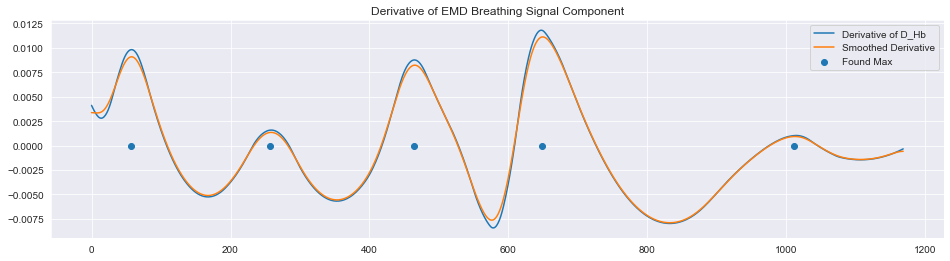

In [12]:
imf = emd.sift.sift(d_hb)
levels = (imf[:, 4]+imf[:, 5])[90*50+2170:]
dy = np.diff(levels)
ddy = np.diff(gaussian_filter1d(dy, 10))
pairs = []
zeros = []
first = -1
second = -1
for i in range(len(ddy) - 1):
    if ddy[i] <= 0 and ddy[i + 1] >= 0:
        first = i
    elif ddy[i] >= 0 and ddy[i + 1] <= 0 and first != -1:
        pairs.append((first, i))
        zeros.append(i)
        first = -1
figure, axis = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(dy)
plt.plot(gaussian_filter1d(dy, 10))
plt.scatter(zeros, np.zeros(len(zeros)))
plt.legend(["Derivative of D_Hb", "Smoothed Derivative", "Found Max"])
plt.title("Derivative of EMD Breathing Signal Component")
plt.show()

In [13]:
pulse = 60 / (((zeros[-1] - zeros[0]) / 50) / (len(zeros) - 1))
print("Количество вдохов в минуту:", np.round(pulse, 1))
print("Частота дыхания (Гц):", np.round(pulse / 60, 2))

Количество вдохов в минуту: 12.6
Частота дыхания (Гц): 0.21


<a id='pressure'></a>
### Оценка вариабельности артериального давления

Изменение высоты пиков производной пульсовой компоненты характеризует изменение пульсового давления.

**Оценка вариабельности артериального давления на небольшом участке сигнала**

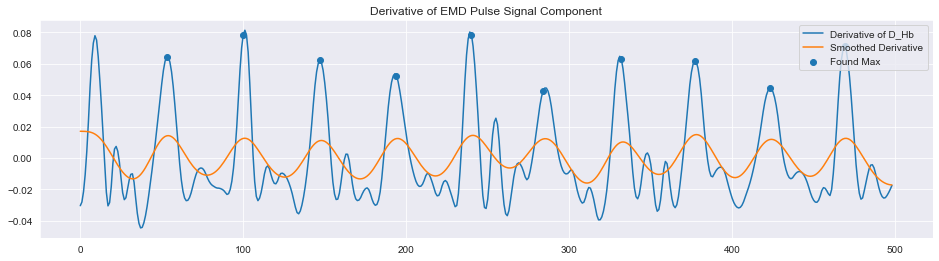

In [14]:
imf = emd.sift.sift(d_hb)
levels = (imf[:, 2]+imf[:, 3])[90*50:100*50]
dy = np.diff(levels)
ddy = np.diff(gaussian_filter1d(dy, 10))
pairs = []
zeros = []
maxes = []
first = -1
second = -1
for i in range(len(ddy) - 1):
    if ddy[i] <= 0 and ddy[i + 1] >= 0:
        first = i
    elif ddy[i] >= 0 and ddy[i + 1] <= 0 and first != -1:
        pairs.append((first, i))
        zeros.append(i)
        maxes.append(dy[i])
        first = -1
figure, axis = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(dy)
plt.plot(gaussian_filter1d(dy, 10))
plt.scatter(zeros, maxes)
plt.legend(["Derivative of D_Hb", "Smoothed Derivative", "Found Max"])
plt.title("Derivative of EMD Pulse Signal Component")
plt.show()

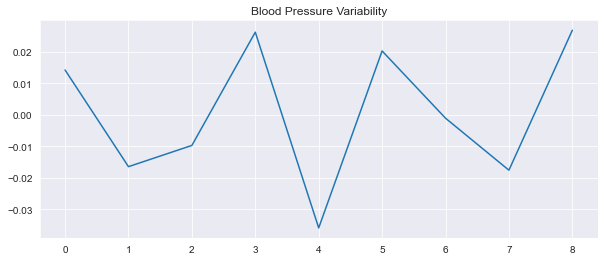

In [15]:
diffs = []
for i in range(len(maxes)-1):
    diffs.append((maxes[i+1] - maxes[i]))
figure, axis = plt.subplots(1, 1, figsize=(10, 4))
plt.plot(diffs)
plt.title("Blood Pressure Variability")
plt.show()

**Оценка вариабельности артериального давления для всего сигнала**

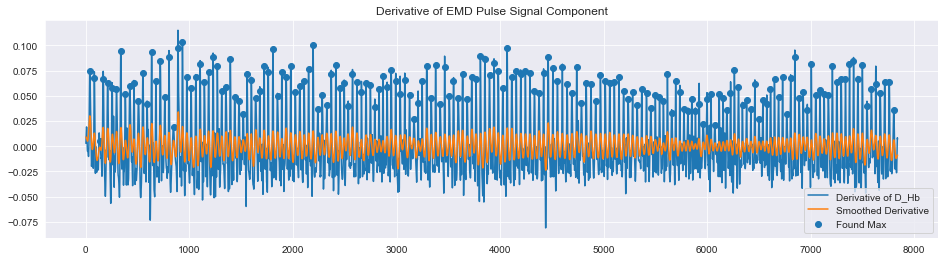

In [16]:
imf = emd.sift.sift(d_hb)
levels = imf[:, 2]+imf[:, 3]
dy = np.diff(levels)
ddy = np.diff(gaussian_filter1d(dy, 10))
pairs = []
zeros = []
maxes = []
first = -1
second = -1
for i in range(len(ddy) - 1):
    if ddy[i] <= 0 and ddy[i + 1] >= 0:
        first = i
    elif ddy[i] >= 0 and ddy[i + 1] <= 0 and first != -1:
        pairs.append((first, i))
        zeros.append(i)
        maxes.append(dy[i])
        first = -1
figure, axis = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(dy)
plt.plot(gaussian_filter1d(dy, 10))
plt.scatter(zeros, maxes)
plt.legend(["Derivative of D_Hb", "Smoothed Derivative", "Found Max"])
plt.title("Derivative of EMD Pulse Signal Component")
plt.show()

Гистограмма величин максимумов является информативной для обнаружения изменения давления. При изменении давления на графике возникает второй пик

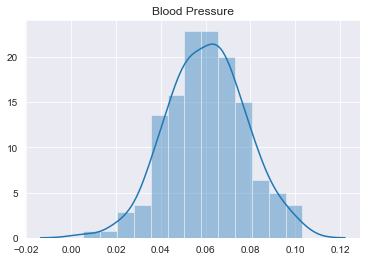

In [17]:
sns.distplot(maxes).set_title("Blood Pressure")
plt.show()

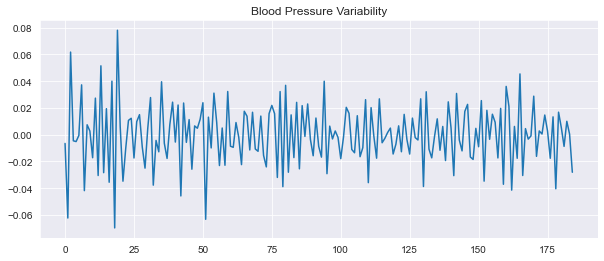

In [18]:
diffs = []
for i in range(len(maxes)-1):
    diffs.append((maxes[i+1] - maxes[i]))
figure, axis = plt.subplots(1, 1, figsize=(10, 4))
plt.plot(diffs)
plt.title("Blood Pressure Variability")
plt.show()

<a id='sat'></a>
### Вычисление артериальной и венозной сатурации

Артериальная и венозная сатурация вычисляются по формулам:

\begin{equation}
    S_aO_2 = \frac{100[\epsilon_{HHb}(\lambda_1) - \epsilon_{HHb}(\lambda_2)(\frac{\Delta \mu a_{пульс}^{\lambda_1}}{\Delta \mu a_{пульс}^{\lambda_2}})]}{[\epsilon_{HHb}(\lambda_1) - \epsilon_{HbO}(\lambda_1)]-[\epsilon_{HHb}(\lambda_2) - \epsilon_{HbO}(\lambda_2)](\frac{\Delta \mu a_{пульс}^{\lambda_1}}{\Delta \mu a_{пульс}^{\lambda_2}})},
\end{equation}

\begin{equation}
    S_vO_2 = \frac{100[\epsilon_{HHb}(\lambda_1) - \epsilon_{HHb}(\lambda_2)(\frac{\Delta \mu a_{дыхат}^{\lambda_1}}{\Delta \mu a_{дыхат}^{\lambda_2}})]}{[\epsilon_{HHb}(\lambda_1) - \epsilon_{HbO}(\lambda_1)]-[\epsilon_{HHb}(\lambda_2) - \epsilon_{HbO}(\lambda_2)](\frac{\Delta \mu a_{дыхат}^{\lambda_1}}{\Delta \mu a_{дыхат}^{\lambda_2}})},
\end{equation}

где $\Delta \mu a_{пульс}^{\lambda_i}$ и $\Delta \mu a_{дыхат}^{\lambda_i}$ вычисляются как амплитуды пульсовой и дыхательной компоненты соответственно на графике преобразования Фурье для d_muA, вычисленного для источника с длиной волны $\lambda_i$

**Вычисление артериальной сатурации**

Вычисление d_muA для длин волн $\lambda_1$ и $\lambda_2$ и расстояния $r_1$ на участке, где основная компонента - пульсовая

In [19]:
df = pd.read_excel(filename)
dc_1 = df["DC 1 A"].values # сигнал, записанный для lmbd2, r1
dc_5 = df["DC 5 A"].values # lmbd1, r1
eps_hhb = {692: 4.7564, 834: 1.7891} #табличные значения для возможных длин волн
eps_hbo = {692: 0.9558, 834: 2.3671}
dpf = 5.9 # табличное значение
d_mua_1 = (1 / (r_1 * dpf)) * np.log(dc_1[0] / dc_1)
d_mua_5 = (1 / (r_1 * dpf)) * np.log(dc_5[0] / dc_5)

Графики полученных сигналов

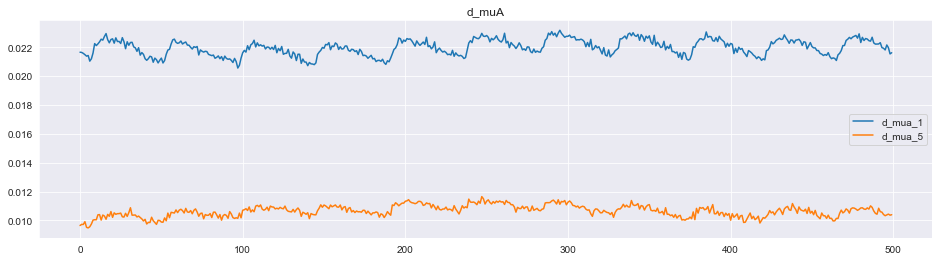

In [20]:
figure, axis = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(d_mua_1[90*50:100*50])
plt.plot(d_mua_5[90*50:100*50])
plt.legend(["d_mua_1", "d_mua_5"])
plt.title("d_muA")
plt.show()

Графики полученных сигналов и их преобразование Фурье

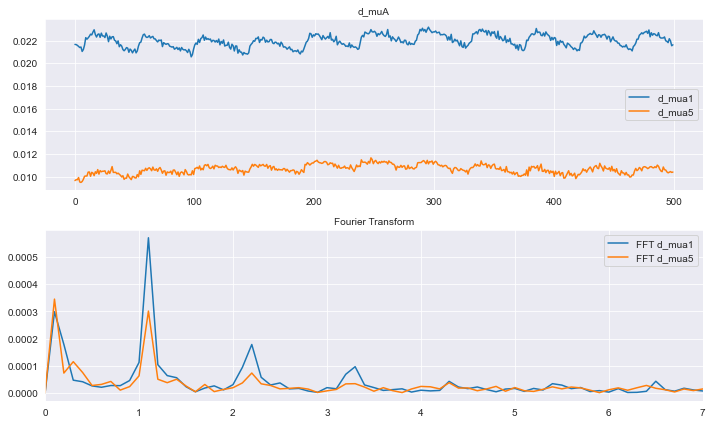

In [21]:
curr_dmua1 = d_mua_1[90*50:100*50]
curr_dmua5 = d_mua_5[90*50:100*50]

N = len(curr_dmua1)
spacing = 1 / 50
fourierTransform = fft(curr_dmua1 - np.average(curr_dmua1))
frequencies = fftfreq(N, spacing)[: N // 2]

figure, axis = plt.subplots(2, 1, figsize=(10, 6))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('d_muA', fontsize=10)
axis[0].plot(curr_dmua1)

axis[1].set_title('Fourier Transform', fontsize=10)
axis[1].plot(frequencies, 2.0 / N * np.abs(fourierTransform[0 : N // 2]))

N = len(curr_dmua5)
spacing = 1 / 50
fourierTransform = fft(curr_dmua5 - np.average(curr_dmua5))
frequencies = fftfreq(N, spacing)[: N // 2]

axis[0].plot(curr_dmua5)

axis[1].plot(frequencies, 2.0 / N * np.abs(fourierTransform[0 : N // 2]))
axis[1].set_xlim(0, 7)

axis[0].legend(["d_mua1", "d_mua5"])

axis[1].legend(["FFT d_mua1", "FFT d_mua5"])

plt.tight_layout()
plt.show()

Поиск максимумов

In [22]:
curr_dmua1 = d_mua_1[90*50:100*50]

N = len(curr_dmua1)
spacing = 1 / 50
fourierTransform = fft(curr_dmua1 - np.average(curr_dmua1))
frequencies = fftfreq(N, spacing)[: N // 2]
fourierT = 2.0 / N * np.abs(fourierTransform[0 : N // 2])[:51]
max_dmua1 = np.max(fourierT[5:15])

curr_dmua5 = d_mua_5[90*50:100*50]

N = len(curr_dmua5)
spacing = 1 / 50
fourierTransform = fft(curr_dmua5 - np.average(curr_dmua5))
frequencies = fftfreq(N, spacing)[: N // 2]
fourierT = 2.0 / N * np.abs(fourierTransform[0 : N // 2])[:51]
max_dmua5 = np.max(fourierT[5:15])

Вычисление артериальной сатурации по формуле

In [23]:
sao2 = (eps_hhb[lmbd_1] - eps_hhb[lmbd_2] * (max_dmua5 / max_dmua1)) * 100
sao2 /= ((eps_hhb[lmbd_1] - eps_hbo[lmbd_1]) - (eps_hhb[lmbd_2] - eps_hbo[lmbd_2]) * \
                (max_dmua5 / max_dmua1))

In [24]:
print("Артериальная сатурация:", np.round(sao2, 1))

Артериальная сатурация: 92.8


**Вычисление венозной сатурации**

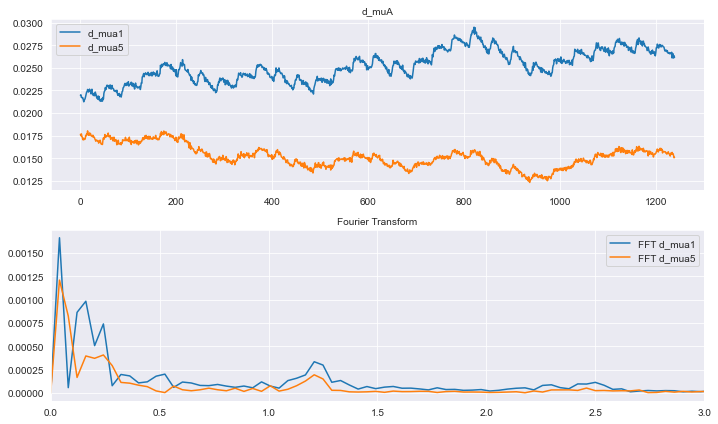

In [25]:
curr_dmua1 = d_mua_1[90*50+2100:]
curr_dmua5 = d_mua_5[90*50+2100:]

N = len(curr_dmua1)
spacing = 1 / 50
fourierTransform = fft(curr_dmua1 - np.average(curr_dmua1))
frequencies = fftfreq(N, spacing)[: N // 2]

figure, axis = plt.subplots(2, 1, figsize=(10, 6))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('d_muA', fontsize=10)
axis[0].plot(curr_dmua1)

axis[1].set_title('Fourier Transform', fontsize=10)
axis[1].plot(frequencies, 2.0 / N * np.abs(fourierTransform[0 : N // 2]))
axis[1].set_xlim(0, 3)

N = len(curr_dmua5)
spacing = 1 / 50
fourierTransform = fft(curr_dmua5 - np.average(curr_dmua5))
frequencies = fftfreq(N, spacing)[: N // 2]

axis[0].plot(curr_dmua5)

axis[1].plot(frequencies, 2.0 / N * np.abs(fourierTransform[0 : N // 2]))
axis[1].set_xlim(0, 3)

axis[0].legend(["d_mua1", "d_mua5"])

axis[1].legend(["FFT d_mua1", "FFT d_mua5"])

plt.tight_layout()
plt.show()

In [26]:
curr_dmua1 = d_mua_1[90*50+2100:]

N = len(curr_dmua1)
spacing = 1 / 50
fourierTransform = fft(curr_dmua1 - np.average(curr_dmua1))
frequencies = fftfreq(N, spacing)[: N // 2]
fourierT = 2.0 / N * np.abs(fourierTransform[0 : N // 2])[:51]
max_dmua1 = np.max(fourierT[5])

curr_dmua5 = d_mua_5[90*50+2100:]

N = len(curr_dmua5)
spacing = 1 / 50
fourierTransform = fft(curr_dmua5 - np.average(curr_dmua5))
frequencies = fftfreq(N, spacing)[: N // 2]
fourierT = 2.0 / N * np.abs(fourierTransform[0 : N // 2])[:51]
max_dmua5 = np.max(fourierT[5])

In [27]:
svo2 = (eps_hhb[lmbd_1] - eps_hhb[lmbd_2] * (max_dmua5 / max_dmua1)) * 100
svo2 /= ((eps_hhb[lmbd_1] - eps_hbo[lmbd_1]) - (eps_hhb[lmbd_2] - eps_hbo[lmbd_2]) * \
                (max_dmua5 / max_dmua1))
print("Венозная сатурация:", np.round(svo2, 1))

Венозная сатурация: 81.6
